In [ ]:
#preprocessing again, this time modifying band pass filter lower cutoff from 0.5Hz to 0.05 Hz

#MOST CORRECT ONE THAT HAS BEEN USED IN ECG_HYBRID_CNN_LSTM_FOCAL_LOSS.ipynb

In [30]:
import pandas as pd
import numpy as np
import wfdb
from wfdb.io import rdrecord
import pywt
from tqdm import tqdm
from scipy.signal import medfilt, butter, filtfilt
import matplotlib.pyplot as plt
import os



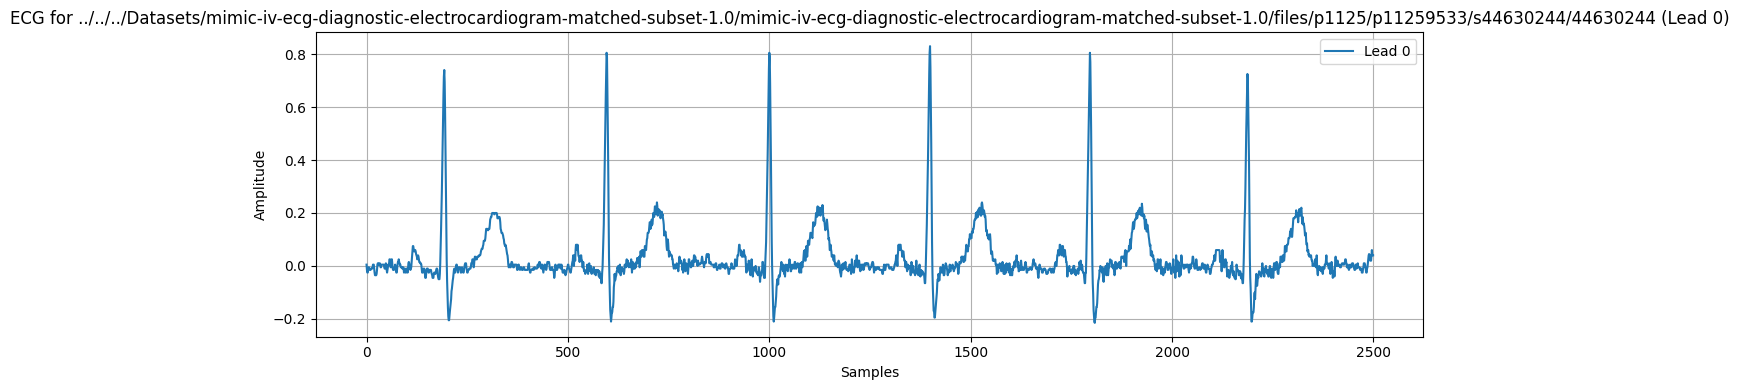

In [24]:
#reading unprocessed signal from original dataset


def plot_ecg_from_hea(hea_path, lead=0, duration=None):
    """
    Plot ECG signal from a .hea file and its corresponding .dat file.

    Parameters:
    - hea_path (str): Full path to the .hea file
    - lead (int): Index of the lead to plot (default = 0)
    - duration (int or None): Number of samples to plot (default = full signal)
    """

    # Remove .hea extension to get the record name
    record_path = os.path.splitext(hea_path)[0]
    
    try:
        # Read the record (will auto-locate associated .dat file)
        record = wfdb.rdrecord(record_path)

        # Extract signal and metadata
        signal = record.p_signal[:, lead]
        fs = record.fs
        sig_len = len(signal)

        # Limit number of samples if specified
        if duration:
            signal = signal[:duration]
        
        # Plotting
        plt.figure(figsize=(12, 4))
        plt.plot(signal, label=f"Lead {lead}")
        plt.title(f"ECG for {record_path.split(os.sep)[-1]} (Lead {lead})")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"Error loading ECG from {hea_path}: {e}")

plot_ecg_from_hea("../../../Datasets/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/files/p1125/p11259533/s44630244/44630244", lead=0, duration=2500)


In [ ]:
# --- Config ---
CSV_PATH = 'preprocessed_ecg_patients.csv'
OUTPUT_CSV = 'baseline_filtered_ecg_patients_2.csv'
SAVE_DIR = 'preprocessed_numpy_signals_2'
LEAD_COUNT = 12
SAMPLES_PER_RECORD = 2500
FS = 500 # Hz 

In [26]:
#denoise
def dwt_denoise(signal, wavelet='db6', level=3):
    denoised = []
    for i in range(signal.shape[1]):
        coeffs = pywt.wavedec(signal[:, i], wavelet, level=level)
        sigma = (1 / 0.6745) * np.median(np.abs(coeffs[-level]))
        uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
        coeffs[1:] = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs[1:]]
        clean = pywt.waverec(coeffs, wavelet)
        denoised.append(clean[:len(signal)])
    return np.stack(denoised, axis=1)

In [27]:
# --- Baseline Correction ---
def baseline_correction(signal, kernel_size=201):
    corrected = np.zeros_like(signal)
    for lead in range(signal.shape[1]):
        baseline = medfilt(signal[:, lead], kernel_size)
        corrected[:, lead] = signal[:, lead] - baseline
    return corrected

In [28]:
# --- Bandpass Filter (CORRECTED FOR FEATURE EXTRACTION) ---
# DANGER: lowcut=0.5 distorts ST and T waves.
# FIX: Use 0.05 to preserve low-frequency diagnostic information.
def bandpass_filter(signal, fs=500, lowcut=0.05, highcut=40, order=4): 
    nyq = 0.5 * fs
    order_val = order if order % 2 == 0 else order + 1
    
    b, a = butter(order_val, [lowcut / nyq, highcut / nyq], btype='band') 
    filtered = np.zeros_like(signal)
    for lead in range(signal.shape[1]):
        filtered[:, lead] = filtfilt(b, a, signal[:, lead])
    return filtered

In [29]:
# --- Create save directory ---
os.makedirs(SAVE_DIR, exist_ok=True)

# --- Load and sample CSV ---
df = pd.read_csv(CSV_PATH)
df = df.sample(frac=0.2, random_state=42).reset_index(drop=True)

processed_rows = []

In [ ]:
# --- Preprocess and save ---
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Preprocessing and Saving"):
    original_path = row['hea_path']
    # Create a dictionary of the original row data to modify
    new_row = row.to_dict() 
    
    try:
        # 1. READ FIX: Uses os.path.join('..', original_path) to correct relative path
        corrected_hea_path = os.path.join('..', original_path)
        record_path = corrected_hea_path[:-4]  # remove .hea
        # Using rdrecord from wfdb library
        record = rdrecord(record_path) 
        signal = record.p_signal

        if signal.shape[0] < SAMPLES_PER_RECORD:
            pad = SAMPLES_PER_RECORD - signal.shape[0]
            signal = np.pad(signal, ((0, pad), (0, 0)), mode='constant')
        signal = signal[:SAMPLES_PER_RECORD, :LEAD_COUNT]

        # Step-by-step filtering
        denoised = dwt_denoise(signal)
        corrected = baseline_correction(denoised)
        final = bandpass_filter(corrected, fs=FS)

        # 2. Define save path and save .npy
        relative_path = original_path.split('files')[-1].replace('.hea', '.npy')
        save_path = os.path.join(SAVE_DIR, relative_path.lstrip(os.sep))
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        np.save(save_path, final)

        # 3. CRITICAL CHANGE: Save the ABSOLUTE path to the processed file
        # This guarantees portability for subsequent scripts.
        new_row['processed_npy_path'] = os.path.abspath(save_path) 
        
        processed_rows.append(new_row)

    except Exception as e:
        print(f"Skipped {original_path}: {e}")

Preprocessing and Saving:   4%|▍         | 1394/31920 [01:50<41:53, 12.14it/s]d:\Shreya Soni\Desktop\College\Capstone\CodeFiles\venv\Lib\site-packages\pywt\_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)
Preprocessing and Saving: 100%|██████████| 31920/31920 [41:16<00:00, 12.89it/s] 


In [32]:
# --- Save updated metadata ---
output_df = pd.DataFrame(processed_rows)
output_df.to_csv(OUTPUT_CSV, index=False)

print(f"\nProcessed and saved {len(output_df)} ECG signals.")
print(f"Metadata saved to '{OUTPUT_CSV}' with absolute paths in 'processed_npy_path'.")


Processed and saved 31920 ECG signals.
Metadata saved to 'baseline_filtered_ecg_patients_2.csv' with absolute paths in 'processed_npy_path'.


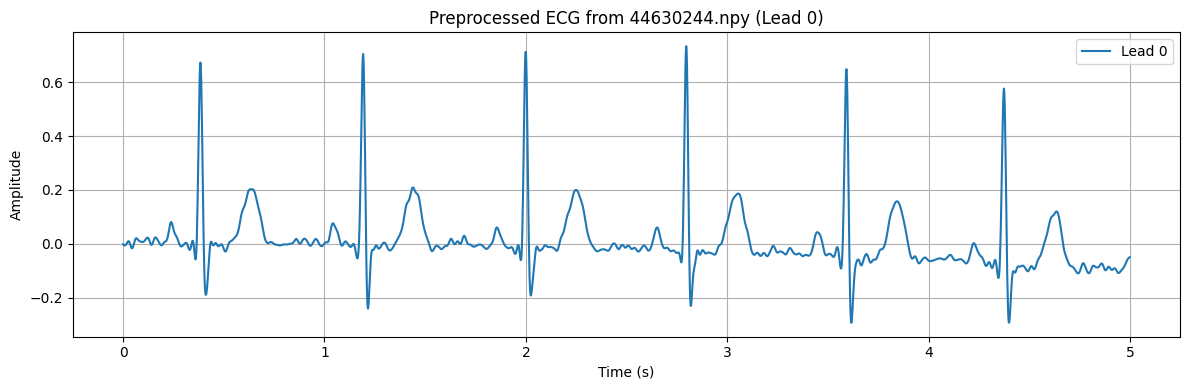

In [33]:
#reading preprocessed signal (.npy)

def plot_ecg_from_npy(npy_path, lead=0, fs=500):
    """
    Plot ECG signal stored in a .npy file (preprocessed).

    Parameters:
    - npy_path (str): Full path to the .npy file containing ECG data
    - lead (int): Index of the lead to plot (default = 0, for multilead arrays)
    - fs (int): Sampling frequency (default = 500 Hz for MIMIC-IV waveform DB)
    """

    try:
        signal = np.load(npy_path)

        # Handle multilead ECGs (shape: [leads, samples] or [samples, leads])
        if signal.ndim == 2:
            # Auto-detect orientation
            if signal.shape[0] < signal.shape[1]:
                signal = signal[lead, :]
            else:
                signal = signal[:, lead]

        time = np.arange(len(signal)) / fs

        plt.figure(figsize=(12, 4))
        plt.plot(time, signal, label=f"Lead {lead}")
        plt.title(f"Preprocessed ECG from {os.path.basename(npy_path)} (Lead {lead})")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error loading or plotting {npy_path}: {e}")

plot_ecg_from_npy("./preprocessed_numpy_signals_2/p1125/p11259533/s44630244/44630244.npy")

In [ ]:
# #not needed
# #add numpy_path as a column to the csv file

# import pandas as pd
# import os

# # Load CSV
# csv_path = "baseline_filtered_ecg_wrongfilename.csv"
# df = pd.read_csv(csv_path)

# # Create npy_path column
# df['npy_path'] = df['path'].apply(
#     lambda p: os.path.splitext(p.replace("files", "preprocessed_numpy_signals"))[0] + '.npy'
# )

# # Save updated CSV
# df.to_csv("baseline_filtered_ecg_patients_with_npy.csv", index=False)
# print("npy_path column added and CSV saved as baseline_filtered_ecg_patients_with_npy.csv")


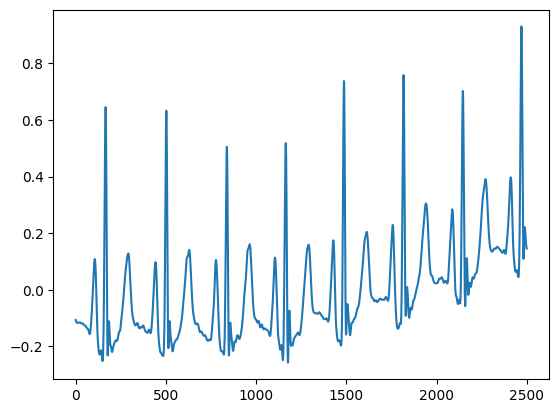

In [35]:
import matplotlib.pyplot as plt
signal_path = "preprocessed_numpy_signals_2/p1000/p10000032/s40689238/40689238.npy"
sig = np.load(signal_path)
plt.plot(sig[:,1])  # Lead II, without transpose
plt.show()

In [ ]:
# import pandas as pd
# import numpy as np
# import wfdb
# from wfdb.io import rdrecord
# import pywt
# from tqdm import tqdm
# from scipy.signal import medfilt, butter, filtfilt
# import matplotlib.pyplot as plt
# import os


# # --- Config ---
# CSV_PATH = 'preprocessed_ecg_patients.csv'
# OUTPUT_CSV = 'baseline_filtered_ecg_patients_2.csv'
# SAVE_DIR = 'preprocessed_numpy_signals_2'
# LEAD_COUNT = 12
# SAMPLES_PER_RECORD = 2500
# FS = 500 # Hz 

# #denoise
# def dwt_denoise(signal, wavelet='db6', level=3):
#     denoised = []
#     for i in range(signal.shape[1]):
#         coeffs = pywt.wavedec(signal[:, i], wavelet, level=level)
#         sigma = (1 / 0.6745) * np.median(np.abs(coeffs[-level]))
#         uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
#         coeffs[1:] = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs[1:]]
#         clean = pywt.waverec(coeffs, wavelet)
#         denoised.append(clean[:len(signal)])
#     return np.stack(denoised, axis=1)

# # --- Baseline Correction ---
# def baseline_correction(signal, kernel_size=201):
#     corrected = np.zeros_like(signal)
#     for lead in range(signal.shape[1]):
#         baseline = medfilt(signal[:, lead], kernel_size)
#         corrected[:, lead] = signal[:, lead] - baseline
#     return corrected

# # --- Bandpass Filter (CORRECTED FOR FEATURE EXTRACTION) ---
# # DANGER: lowcut=0.5 distorts ST and T waves.
# # FIX: Use 0.05 to preserve low-frequency diagnostic information.
# def bandpass_filter(signal, fs=500, lowcut=0.05, highcut=40, order=4): 
#     nyq = 0.5 * fs
#     order_val = order if order % 2 == 0 else order + 1
    
#     b, a = butter(order_val, [lowcut / nyq, highcut / nyq], btype='band') 
#     filtered = np.zeros_like(signal)
#     for lead in range(signal.shape[1]):
#         filtered[:, lead] = filtfilt(b, a, signal[:, lead])
#     return filtered

# # --- Create save directory ---
# os.makedirs(SAVE_DIR, exist_ok=True)

# # --- Load and sample CSV ---
# df = pd.read_csv(CSV_PATH)
# df = df.sample(frac=0.2, random_state=42).reset_index(drop=True)

# processed_rows = []

# # --- Preprocess and save ---
# for idx, row in tqdm(df.iterrows(), total=len(df), desc="Preprocessing and Saving"):
#     original_path = row['hea_path']
#     # Create a dictionary of the original row data to modify
#     new_row = row.to_dict() 
    
#     try:
#         # 1. READ FIX: Uses os.path.join('..', original_path) to correct relative path
#         corrected_hea_path = os.path.join('..', original_path)
#         record_path = corrected_hea_path[:-4]  # remove .hea
#         # Using rdrecord from wfdb library
#         record = rdrecord(record_path) 
#         signal = record.p_signal

#         if signal.shape[0] < SAMPLES_PER_RECORD:
#             pad = SAMPLES_PER_RECORD - signal.shape[0]
#             signal = np.pad(signal, ((0, pad), (0, 0)), mode='constant')
#         signal = signal[:SAMPLES_PER_RECORD, :LEAD_COUNT]

#         # Step-by-step filtering
#         denoised = dwt_denoise(signal)
#         corrected = baseline_correction(denoised)
#         final = bandpass_filter(corrected, fs=FS)

#         # 2. Define save path and save .npy
#         relative_path = original_path.split('files')[-1].replace('.hea', '.npy')
#         save_path = os.path.join(SAVE_DIR, relative_path.lstrip(os.sep))
#         os.makedirs(os.path.dirname(save_path), exist_ok=True)
#         np.save(save_path, final)

#         # 3. CRITICAL CHANGE: Save the ABSOLUTE path to the processed file
#         # This guarantees portability for subsequent scripts.
#         new_row['processed_npy_path'] = os.path.abspath(save_path) 
        
#         processed_rows.append(new_row)

#     except Exception as e:
#         print(f"Skipped {original_path}: {e}")
        
# # --- Save updated metadata ---
# output_df = pd.DataFrame(processed_rows)
# output_df.to_csv(OUTPUT_CSV, index=False)

# print(f"\nProcessed and saved {len(output_df)} ECG signals.")
# print(f"Metadata saved to '{OUTPUT_CSV}' with absolute paths in 'processed_npy_path'.")